### Importing the dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [3]:
from xgboost import XGBRegressor
print("XGBoost imported successfully!")


XGBoost imported successfully!


### Data Collecting and Processing

In [5]:
import pandas as pd
import zipfile

# Path to your ZIP file
zip_path = r"C:\Users\LAMIYA\Downloads\swimming_datasets.zip"

# Open the zip
with zipfile.ZipFile(zip_path) as z:
    # List files in the ZIP
    print("Files in zip:", z.namelist())
    
    # Read calories.xlsx/csv
    with z.open('calories.csv') as f:
        calories = pd.read_csv(f)  # use read_excel(f) if they are xlsx
    
    # Read swimming_sessions.xlsx/csv
    with z.open('swimming_sessions.csv') as f:
        swimming_sessions = pd.read_csv(f)  # use read_excel(f) if they are xlsx

# Preview
print(calories.head())
print(swimming_sessions.head())



Files in zip: ['swimming_sessions.csv', 'calories.csv']
   User_Id  Calories
0        1    204.07
1        1    473.50
2        1    114.44
3        1    317.93
4        1    478.51
   User_Id  Gender  Age  Height  Weight  Duration       Stroke_Type  \
0        1  Female   48     180      70        19      Breaststroke   
1        1  Female   48     180      70        39  Freestyle (fast)   
2        1  Female   48     180      70        10        Backstroke   
3        1  Female   48     180      70        47  Freestyle (slow)   
4        1  Female   48     180      70        37      Breaststroke   

   Lap_Count  Distance_m  Heart_Rate  Water_Temperature  Body_Temp  
0         62        1550         168               28.7       38.7  
1         34         850         137               28.1       37.5  
2        147        3675         145               28.6       38.0  
3        154        3850         136               27.2       36.7  
4        120        3000         124          

### Combinig the two datasets

In [7]:
# Combine features and target into one DataFrame
calories_data = pd.concat([swimming_sessions, calories['Calories']], axis=1)

# Preview
print(calories_data.head())


   User_Id  Gender  Age  Height  Weight  Duration       Stroke_Type  \
0        1  Female   48     180      70        19      Breaststroke   
1        1  Female   48     180      70        39  Freestyle (fast)   
2        1  Female   48     180      70        10        Backstroke   
3        1  Female   48     180      70        47  Freestyle (slow)   
4        1  Female   48     180      70        37      Breaststroke   

   Lap_Count  Distance_m  Heart_Rate  Water_Temperature  Body_Temp  Calories  
0         62        1550         168               28.7       38.7    204.07  
1         34         850         137               28.1       37.5    473.50  
2        147        3675         145               28.6       38.0    114.44  
3        154        3850         136               27.2       36.7    317.93  
4        120        3000         124               29.1       37.8    478.51  


In [8]:
print(calories_data.shape)

(7457, 13)


In [9]:
print(calories_data.info)

<bound method DataFrame.info of       User_Id  Gender  Age  Height  Weight  Duration       Stroke_Type  \
0           1  Female   48     180      70        19      Breaststroke   
1           1  Female   48     180      70        39  Freestyle (fast)   
2           1  Female   48     180      70        10        Backstroke   
3           1  Female   48     180      70        47  Freestyle (slow)   
4           1  Female   48     180      70        37      Breaststroke   
...       ...     ...  ...     ...     ...       ...               ...   
7452     1000    Male   34     193      68        85        Backstroke   
7453     1000    Male   34     193      68        22  Freestyle (slow)   
7454     1000    Male   34     193      68        57  Freestyle (slow)   
7455     1000    Male   34     193      68        76        Backstroke   
7456     1000    Male   34     193      68        10  Freestyle (slow)   

      Lap_Count  Distance_m  Heart_Rate  Water_Temperature  Body_Temp  \
0     

### Data Cleaning

In [11]:
calories_data.isnull().sum()

User_Id              0
Gender               0
Age                  0
Height               0
Weight               0
Duration             0
Stroke_Type          0
Lap_Count            0
Distance_m           0
Heart_Rate           0
Water_Temperature    0
Body_Temp            0
Calories             0
dtype: int64

In [12]:
import numpy as np

# Stroke intensity factors
stroke_factor = {
    'Freestyle (fast)': 1.3,
    'Freestyle (slow)': 1.1,
    'Backstroke': 1.0,
    'Breaststroke': 1.05,
    'Butterfly': 1.5
}

# Realistic calorie calculation
calories_data['Calories'] = (
    0.2 * calories_data['Distance_m'] +   # distance contribution
    8 * calories_data['Duration'] +       # calories per minute
    0.3 * calories_data['Heart_Rate'] +  # intensity effect
    0.25 * calories_data['Weight']       # weight effect
) * calories_data['Stroke_Type'].map(stroke_factor)

# Add small random noise to simulate variability
calories_data['Calories'] += np.random.normal(0, 20, size=len(calories_data))

# Preview
print(calories_data[['Distance_m', 'Duration', 'Heart_Rate', 'Weight', 'Stroke_Type', 'Calories']].head())



   Distance_m  Duration  Heart_Rate  Weight       Stroke_Type     Calories
0        1550        19         168      70      Breaststroke   573.796147
1         850        39         137      70  Freestyle (fast)   751.102474
2        3675        10         145      70        Backstroke   901.717894
3        3850        47         136      70  Freestyle (slow)  1335.330794
4        3000        37         124      70      Breaststroke  1031.346396


### Data Analysis

In [14]:
# get some statistical measures about the data
calories_data.describe()

,User_Id,Age,Height,Weight,Duration,Lap_Count,Distance_m,Heart_Rate,Water_Temperature,Body_Temp,Calories
count,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000,7457.000000
mean,499.726029,40.980823,175.728443,74.793080,49.539359,94.345313,2358.632828,145.584820,27.501944,37.757208,1107.877108
std,288.605912,13.665563,14.686683,14.550672,23.523789,49.048112,1226.202790,20.496659,1.443803,0.722238,407.655597
min,1.000000,18.000000,150.000000,50.000000,10.000000,10.000000,250.000000,110.000000,25.000000,36.500000,190.683932
25%,250.000000,29.000000,163.000000,62.000000,29.000000,51.000000,1275.000000,128.000000,26.300000,37.100000,815.103366
50%,498.000000,41.000000,176.000000,75.000000,49.000000,94.000000,2350.000000,146.000000,27.500000,37.800000,1079.415586
75%,749.000000,53.000000,189.000000,87.000000,70.000000,136.000000,3400.000000,163.000000,28.800000,38.400000,1371.301317
max,1000.000000,65.000000,200.000000,100.000000,90.000000,180.000000,4500.000000,180.000000,30.000000,39.000000,2501.610055


### Data Visualization

#### Gender distribution Plot

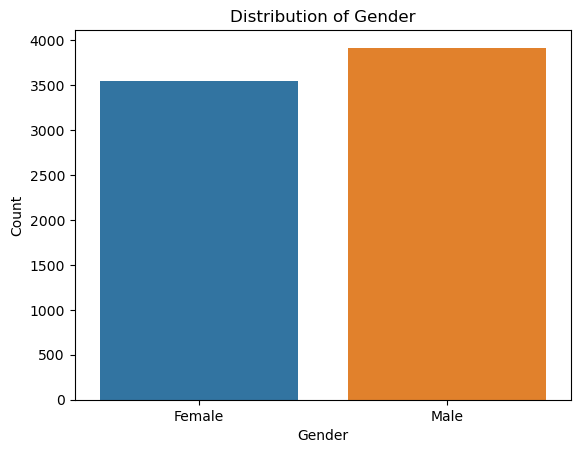

In [17]:
# Plot the Gender distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot with colors and no hue
sns.countplot(x='Gender', data=calories_data, hue='Gender', palette=['#1f77b4', '#ff7f0e'], dodge=False)
plt.title("Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend([],[], frameon=False)  # Remove the legend since hue duplicates it
plt.show()


#### Age Distribution Plot

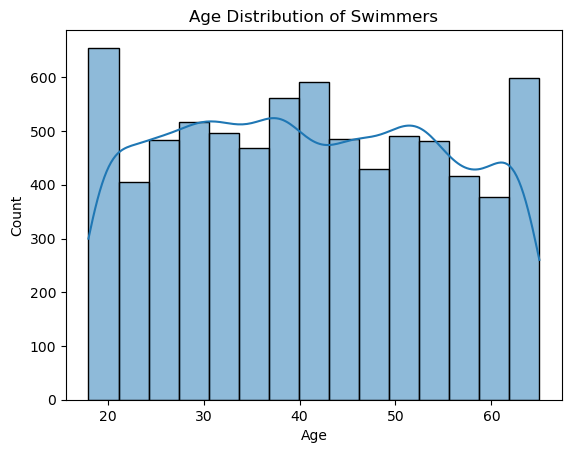

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Age
sns.histplot(calories_data['Age'], bins=15, kde=True, color="#1f77b4")
plt.title("Age Distribution of Swimmers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


### Height and Weight Distribution Plots

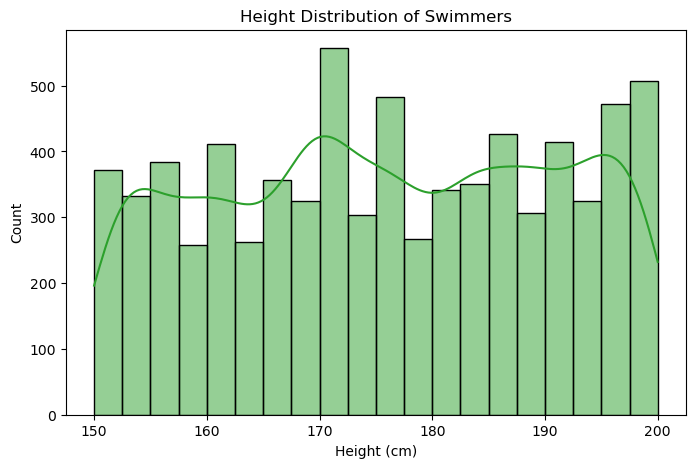

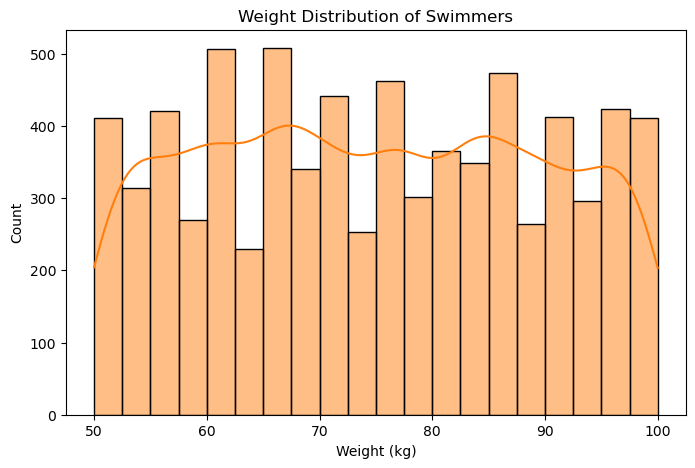

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Height distribution
plt.figure(figsize=(8,5))
sns.histplot(calories_data['Height'], bins=20, kde=True, color="#2ca02c")
plt.title("Height Distribution of Swimmers")
plt.xlabel("Height (cm)")
plt.ylabel("Count")
plt.show()

# Weight distribution
plt.figure(figsize=(8,5))
sns.histplot(calories_data['Weight'], bins=20, kde=True, color="#ff7f0e")
plt.title("Weight Distribution of Swimmers")
plt.xlabel("Weight (kg)")
plt.ylabel("Count")
plt.show()


### Distribution of Swimming Strokes

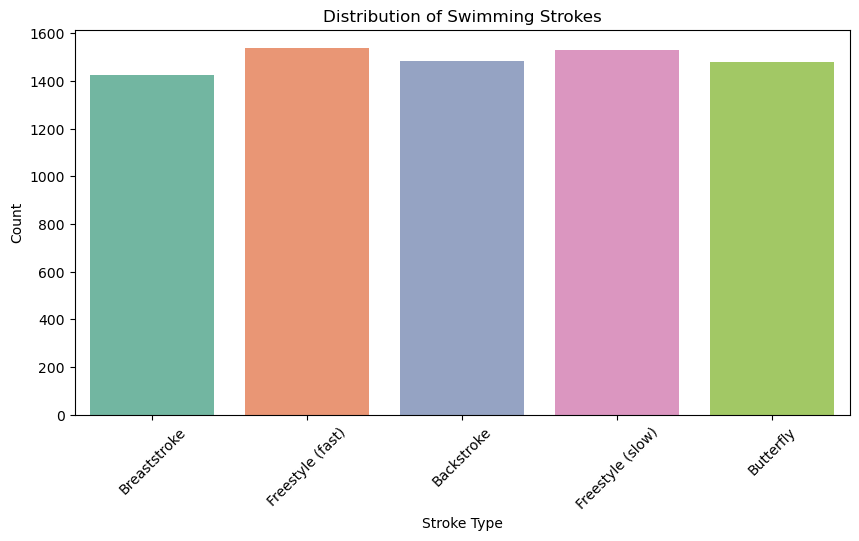

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.countplot(x='Stroke_Type', data=calories_data, hue='Stroke_Type', palette='Set2', dodge=False)
plt.title("Distribution of Swimming Strokes")
plt.xlabel("Stroke Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # remove redundant legend
plt.show()




### Calories Burnt By Stroke Type

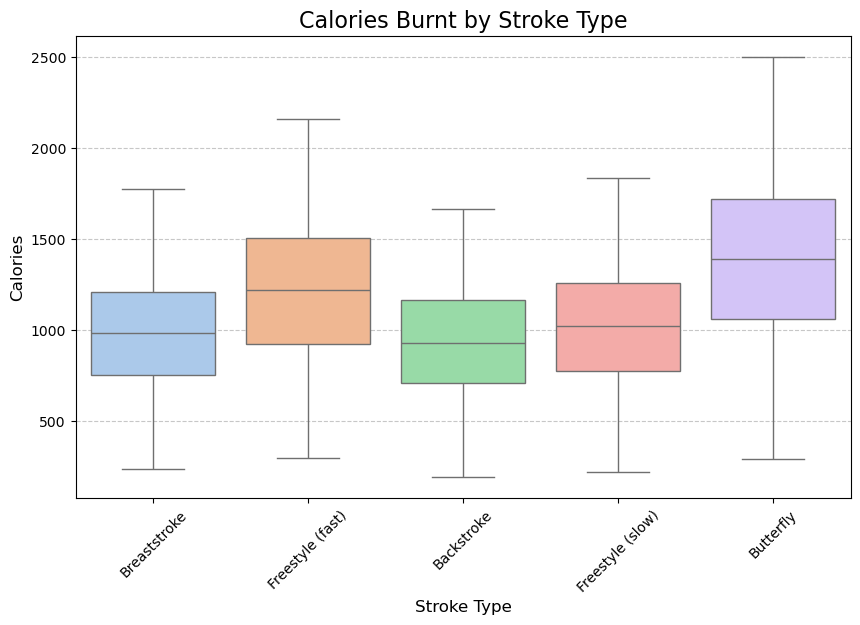

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(
    x='Stroke_Type', 
    y='Calories', 
    data=calories_data, 
    hue='Stroke_Type',       # satisfy new Seaborn requirement
    palette='pastel', 
    dodge=False,             # prevent splitting bars
    showfliers=True
)
plt.title("Calories Burnt by Stroke Type", fontsize=16)
plt.xlabel("Stroke Type", fontsize=12)
plt.ylabel("Calories", fontsize=12)
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # hide redundant legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Calories vs Duration 

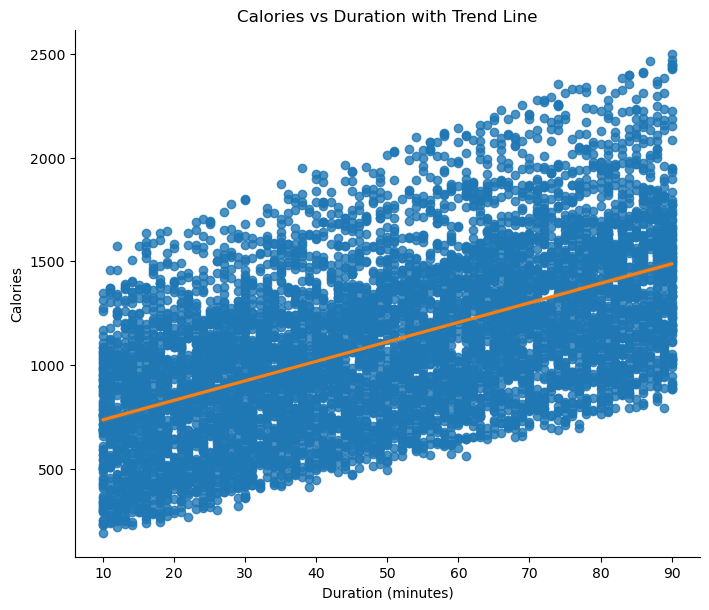

In [27]:
sns.lmplot(x='Duration', y='Calories', data=calories_data, height=6, aspect=1.2, scatter_kws={'color':'#1f77b4'}, line_kws={'color':'#ff7f0e'})
plt.title("Calories vs Duration with Trend Line")
plt.xlabel("Duration (minutes)")
plt.ylabel("Calories")
plt.show()

In [28]:
calories_data[['Distance_m', 'Calories']].corr()


,Distance_m,Calories
Distance_m,1.000000,0.702473
Calories,0.702473,1.000000


### Calories vs Distance

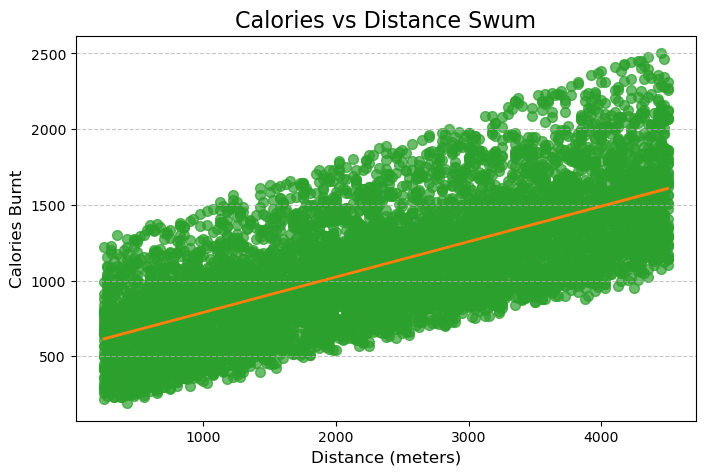

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

# Scatter plot with regression line
sns.regplot(
    x='Distance_m',
    y='Calories',
    data=calories_data,
    scatter_kws={'color':'#2ca02c', 's':50, 'alpha':0.7},  # points
    line_kws={'color':'#ff7f0e', 'linewidth':2}           # regression line
)

plt.title("Calories vs Distance Swum", fontsize=16)
plt.xlabel("Distance (meters)", fontsize=12)
plt.ylabel("Calories Burnt", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Correlation Heatmap (Numeric Features Only)

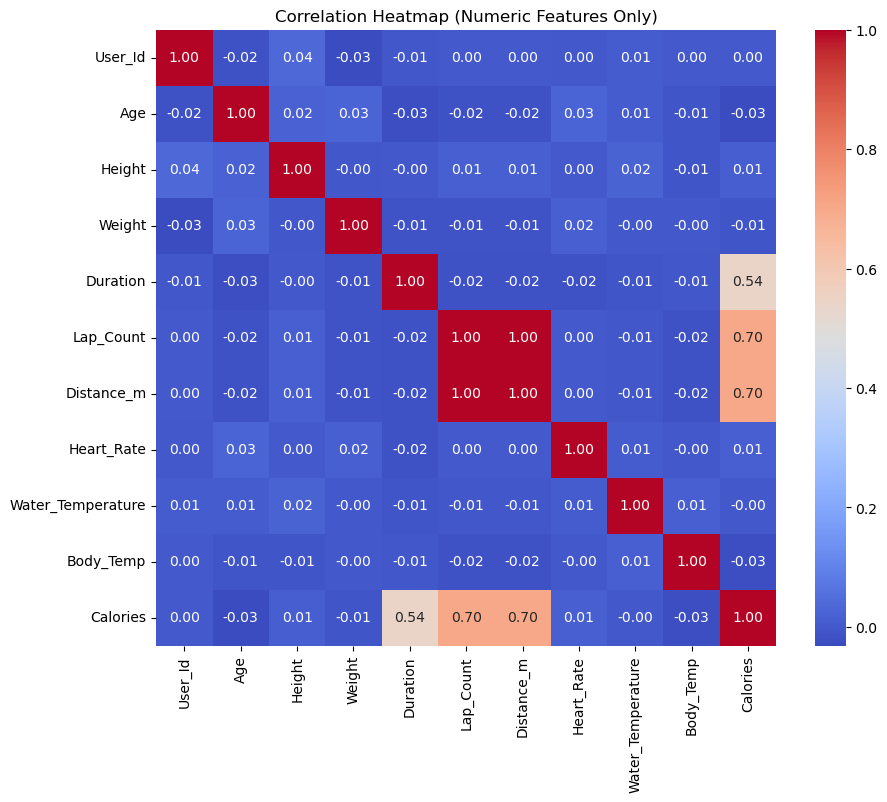

In [32]:
plt.figure(figsize=(10,8))
numeric_cols = calories_data.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


## Converting the text data to numerical values

In [34]:
import pandas as pd

# 1. Label Encode Gender (Male=0, Female=1)
calories_data['Gender'] = calories_data['Gender'].map({'Male': 0, 'Female': 1})

# 2. One-Hot Encode Stroke_Type
calories_data = pd.get_dummies(calories_data, columns=['Stroke_Type'], drop_first=True)

# Check first few rows
print(calories_data.head())


   User_Id  Gender  Age  Height  Weight  Duration  Lap_Count  Distance_m  \
0        1       1   48     180      70        19         62        1550   
1        1       1   48     180      70        39         34         850   
2        1       1   48     180      70        10        147        3675   
3        1       1   48     180      70        47        154        3850   
4        1       1   48     180      70        37        120        3000   

   Heart_Rate  Water_Temperature  Body_Temp     Calories  \
0         168               28.7       38.7   573.796147   
1         137               28.1       37.5   751.102474   
2         145               28.6       38.0   901.717894   
3         136               27.2       36.7  1335.330794   
4         124               29.1       37.8  1031.346396   

   Stroke_Type_Breaststroke  Stroke_Type_Butterfly  \
0                      True                  False   
1                     False                  False   
2                   

### Correlation Heatmap

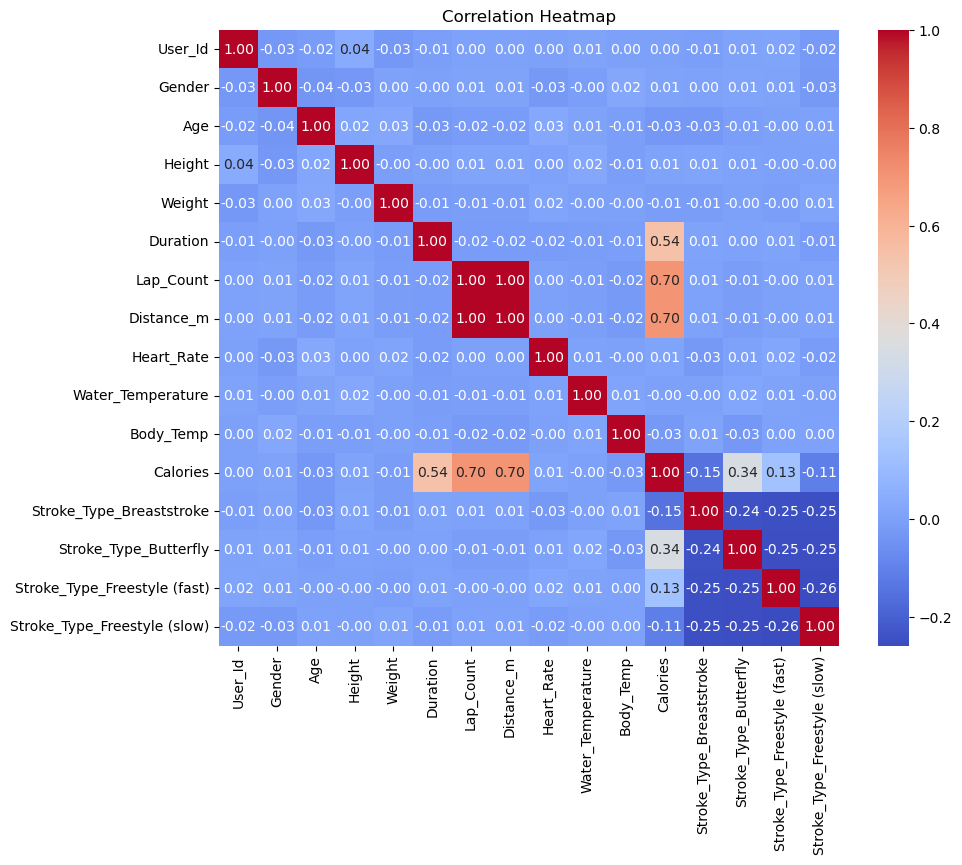

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(calories_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [36]:
calories_data.head()

,User_Id,Gender,Age,Height,Weight,Duration,Lap_Count,Distance_m,Heart_Rate,Water_Temperature,Body_Temp,Calories,Stroke_Type_Breaststroke,Stroke_Type_Butterfly,Stroke_Type_Freestyle (fast),Stroke_Type_Freestyle (slow)
0,1,1,48,180,70,19,62,1550,168,28.7,38.7,573.796147,True,False,False,False
1,1,1,48,180,70,39,34,850,137,28.1,37.5,751.102474,False,False,True,False
2,1,1,48,180,70,10,147,3675,145,28.6,38.0,901.717894,False,False,False,False
3,1,1,48,180,70,47,154,3850,136,27.2,36.7,1335.330794,False,False,False,True
4,1,1,48,180,70,37,120,3000,124,29.1,37.8,1031.346396,True,False,False,False


### Separate Features and Target

In [37]:
# Separate features and target
X = calories_data.drop(columns=['Calories'])  # all columns except Calories
y = calories_data['Calories']                 # only the Calories column

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (7457, 15)
Target shape: (7457,)


In [38]:
print(X)

      User_Id  Gender  Age  Height  Weight  Duration  Lap_Count  Distance_m  \
0           1       1   48     180      70        19         62        1550   
1           1       1   48     180      70        39         34         850   
2           1       1   48     180      70        10        147        3675   
3           1       1   48     180      70        47        154        3850   
4           1       1   48     180      70        37        120        3000   
...       ...     ...  ...     ...     ...       ...        ...         ...   
7452     1000       0   34     193      68        85        180        4500   
7453     1000       0   34     193      68        22        179        4475   
7454     1000       0   34     193      68        57        104        2600   
7455     1000       0   34     193      68        76         42        1050   
7456     1000       0   34     193      68        10        180        4500   

      Heart_Rate  Water_Temperature  Body_Temp  Str

In [39]:
print(y)

0        573.796147
1        751.102474
2        901.717894
3       1335.330794
4       1031.346396
           ...     
7452    1666.355824
7453    1252.518928
7454    1133.712306
7455     901.342699
7456    1140.687899
Name: Calories, Length: 7457, dtype: float64


### Splitting the data into Training data and Testing data

In [40]:
from sklearn.model_selection import train_test_split
X = calories_data.drop(columns=['Calories'])
Y = calories_data['Calories']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (5965, 15)
Test set size: (1492, 15)


### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

### Mean absolute error

In [42]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R² score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

R² score: 0.9792182328429688
Mean Absolute Error: 45.10918611217957


### XGBoost Regressor

In [43]:
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
y_pred = model.predict(X_test)

# Compare first few predictions with actual values
predictions_df = pd.DataFrame({
    "Actual Calories": y_test.values,
    "Predicted Calories": y_pred
})

print(predictions_df.head(10))

   Actual Calories  Predicted Calories
0      1177.933700         1130.176270
1       984.838652          970.365601
2       939.617888          936.142273
3       948.822298          923.109375
4       699.801301          593.955139
5       729.089457          700.157104
6      1790.743989         1794.727417
7      1422.254561         1407.161621
8       629.207394          644.996582
9       587.783958          611.777710


In [45]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 24.550447699355075


Mean Absolute Error: 24.767115786636644
R² score: 0.9942375341519731


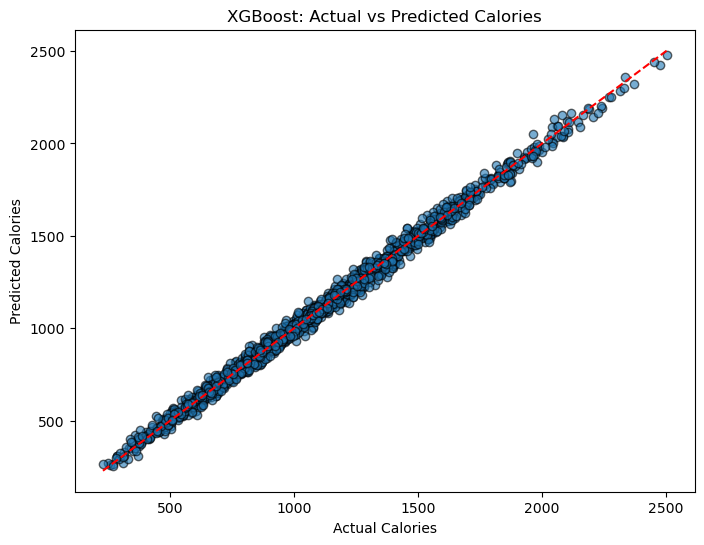

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1. Split data into features (X) and target (Y)
X = calories_data.drop(columns=['Calories'])
Y = calories_data['Calories']

# 2. Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# 3. Create and train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, Y_train)

# 4. Predictions
test_data_prediction_xgb = model_xgb.predict(X_test)

# 5. Mean Absolute Error
mae_xgb = mean_absolute_error(Y_test, test_data_prediction_xgb)
print("Mean Absolute Error:", mae_xgb)

# 6. R² score
r2_xgb = r2_score(Y_test, test_data_prediction_xgb)
print("R² score:", r2_xgb)

# 7. Plot Predicted vs Actual Calories
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, test_data_prediction_xgb, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("XGBoost: Actual vs Predicted Calories")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # 1:1 line
plt.show()
